<div align='center'><font size="5" color='#353B47'>Image Segmentation</font></div>
<div align='center'><font size="4" color="#353B47">Using U-Net with Keras</font></div>
<br>
<hr>

**<font color="#5963ab" size="4">Objective</font>**

> This notebook is dedicated to implementing the U-Net algorithm, a specialized convolutional neural network architecture, to perform a task of image segmentation accurately and efficiently.

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Introduction</a></font>**
**<br><font size="2"><a href="#chap2">2. Load Data</a></font>**
**<br><font size="2"><a href="#chap3">3. Get Masks</a></font>**
**<br><font size="2"><a href="#chap4">4. Training Model</a></font>**
**<br><font size="2"><a href="#chap5">5. Predict and Visualize</a></font>**

# <div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Introduction</h1></div>

**<font color="#5963ab" size="4">What is a a U-net ?</font>**

> The U-Net is a type of convolutional neural network (CNN) that's specifically designed for swift and accurate segmentation of images.



![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

> The illustration depicts the U-Net architecture, using 32x32 pixels at the lowest resolution as an example. In this diagram, each blue box represents a multi-channel feature map. The quantity of channels for each feature map is indicated above the corresponding box, while the spatial dimensions (x-y size) are indicated at the lower left corner of the box. Boxes in white denote feature maps that have been copied from a previous layer. The arrows present in the diagram symbolize various operations carried out in the architecture.
>
> Please note that while this illustration serves as an example of the U-Net architecture, the actual dimensions or layout of the layers can vary, depending on specific use cases or modifications to the architecture.

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Setup</h1></div>

In [2]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Import data</h1></div>

In [4]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH + 'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH + 'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [5]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

# <div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Get groundtruths</h1></div>

In [7]:
# Loop through all train_ids
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    
    # Get the path to the image and mask directories
    path = TRAIN_PATH + id_  
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    
    # Store the processed image into the X_train array at index n
    X_train[n] = img 
    
    # Initialize an empty mask of dimensions IMG_HEIGHT x IMG_WIDTH x 1 with boolean values
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)  
    
    # Loop through each file in the masks directory
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        
        # Read the mask file
        mask_ = imread(path + '/masks/' + mask_file)
        
        # Resize the mask to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant'), and add an extra dimension
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        
        # Merge all the masks associated with the same image by taking the maximum value at each pixel location
        mask = np.maximum(mask, mask_)
    
    # Store the processed mask into the Y_train array at index n
    Y_train[n] = mask

100%|██████████| 670/670 [03:49<00:00,  2.91it/s]


In [8]:
# Create an empty array for test images with dimensions as (number of test images, height, width, channels)
# The datatype for the array is uint8 which can hold values from 0 to 255
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Initialize an empty list to store the original sizes of the test images
sizes_test = []

# Loop through all the test_ids
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    # Get the path to the test image
    path = TEST_PATH + id_
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    
    # Append the original size of the image to sizes_test list
    sizes_test.append([img.shape[0], img.shape[1]])
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Store the processed image into the X_test array at index n
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 59.09it/s]


# <div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Training Unet</h1></div>

In [9]:
# Create a function for a convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

# Create a function for the expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [10]:
# Inputs
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [11]:
# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

In [13]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - 11s 75ms/step - loss: 0.6409 - accuracy: 0.7266 - val_loss: 0.3798 - val_accuracy: 0.7807
Epoch 2/25
38/38 [==============================] - 1s 37ms/step - loss: 0.3279 - accuracy: 0.8230 - val_loss: 0.2333 - val_accuracy: 0.9070
Epoch 3/25
38/38 [==============================] - 1s 37ms/step - loss: 0.1733 - accuracy: 0.9337 - val_loss: 0.1646 - val_accuracy: 0.9356
Epoch 4/25
38/38 [==============================] - 1s 37ms/step - loss: 0.1299 - accuracy: 0.9506 - val_loss: 0.1563 - val_accuracy: 0.9365
Epoch 5/25
38/38 [==============================] - 1s 38ms/step - loss: 0.1304 - accuracy: 0.9507 - val_loss: 0.1415 - val_accuracy: 0.9451
Epoch 6/25
38/38 [==============================] - 1s 38ms/step - loss: 0.1075 - accuracy: 0.9594 - val_loss: 0.1323 - val_accuracy: 0.9482
Epoch 7/25
38/38 [==============================] - 1s 37ms/step - loss: 0.1104 - accuracy: 0.9579 - val_loss: 0.1244 - val_accuracy: 0.9519
Epoch 8/25
3

In [14]:
# Save the trained model to a file
model.save("model_trained.h5")
print("Model saved as model_trained.h5")



Model saved as model_trained.h5


# <div id="chap5"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Inference</h1></div>

In [15]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 82ms/step


In [16]:
# Function to display images
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


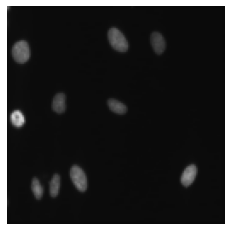

Ground Truth Mask:


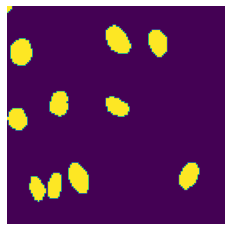

Predicted Mask:


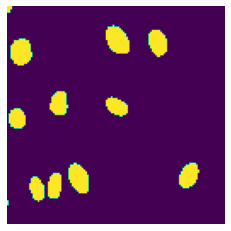

In [17]:
# Select a random index from training set
ix = random.randint(0, len(preds_train_t))

# Display the input image
print("Input Image:")
display_images(X_train[ix])

# Display the ground truth mask
print("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

# Display the predicted mask
print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

Validation Input Image:


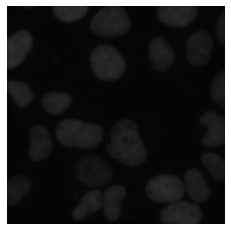

Validation Ground Truth Mask:


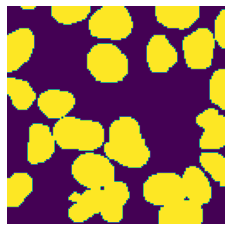

Validation Predicted Mask:


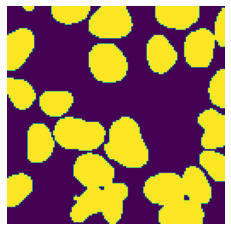

In [18]:
# Select a random index from validation set
ix = random.randint(0, len(preds_val_t))

# Calculate the index from where validation data starts
val_data_start = int(X_train.shape[0] * 0.9)

# Display the validation input image
print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

# Display the validation ground truth mask
print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

# Display the validation predicted mask
print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">I appreciate your time and effort in reading this notebook. My aim is to address your questions and curiosities in a comprehensive and clear manner. I welcome any constructive feedback that will help me improve and motivate me to deliver higher quality content. My primary goal is to share knowledge and learn from others while fueling my passion for the subject. If you found this notebook valuable, please consider upvoting and sharing my work. </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you, and let passion be your guide.</font></div>